# Inventory Dynamics

------

#### John Stachurski
#### Prepared for the CBC Computational Workshop May 2024

-----

## Overview

This lecture explores the inventory dynamics of a firm using so-called s-S inventory control.

Loosely speaking, this means that the firm

- waits until inventory falls below some value $ s $  
- and then restocks with a bulk order of $ S $ units (or, in some models, restocks up to level $ S $).  

This lecture will help use become familiar with NumPy.

(Later we will try similar operations with JAX)

We will use the following imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

## Sample paths

Consider a firm with inventory $ X_t $.

The firm waits until $ X_t \leq s $ and then restocks up to $ S $ units.

It faces stochastic demand $ \{ D_t \} $, which we assume is IID across time and
firms.

With notation $ a^+ := \max\{a, 0\} $, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $ D_t $ is lognormal, so that

$$
    D_t = \exp(\mu + \sigma Z_t)
$$

where $ \mu $ and $ \sigma $ are parameters and $ \{Z_t\} $ is IID
and standard normal.

Here’s a `namedtuple` that stores parameters.

In [2]:
Parameters = namedtuple('Parameters', ['s', 'S', 'μ', 'σ'])

Here's a function that updates from $X_t = x$ to $X_{t+1}$

In [7]:
def update(params, x):
    """
    Update the state from t to t+1 given current state x.
    
    """
    s, S, μ, σ = params
    Z = np.random.randn()
    D = np.exp(μ + σ * Z)
    return max(S - D, 0) if x <= s else max(x - D, 0)

Here's a function that generates a time series.

In [8]:
def sim_inventory_path(x_init, params, sim_length):
    """
    Simulate a time series (X_t) with X_0 = x_init.

    """
    X = np.empty(sim_length)
    X[0] = x_init
    for t in range(sim_length-1):
        X[t+1] = update(params, X[t])
    return X

Let's test it.

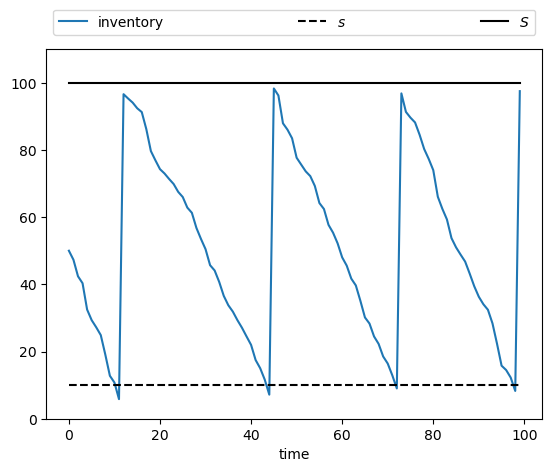

In [9]:
params = Parameters(s=10, S=100, μ=1.0, σ=0.5)
s, S = params.s, params.S
sim_length = 100
x_init = 50

X = sim_inventory_path(x_init, params, sim_length)

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

## Cross-sectional distributions

Now suppose we have a cross-section of firms, where `X[i]` is the inventory of the $i$-th firm.

The following code to updates the cross-section by one period.

(Demand is assumed to be independent across firms.)

In [10]:
def update_cross_section(params, X):
    """
    Update by one period a cross-section of firms with inventory levels 
    given by array X.  (Thus, X[i] is the inventory of the i-th firm.)
    
    """
    s, S, μ, σ = params
    num_firms = len(X)
    Z = np.random.randn(num_firms)
    D = np.exp(μ + σ * Z)
    X_new = np.where(X <= s, np.maximum(S - D, 0), np.maximum(X - D, 0))
    return X_new

### Shifting the cross-section

Now we provide code to compute the cross-sectional distribution $ \psi_T $ given some
initial distribution $ \psi_0 $ and a positive integer $ T $.

In the code below, the initial distribution $ \psi_0 $ takes all firms to have
initial inventory `x_init`.

In [11]:
def shift_cross_section(params, X, T):
    """
    Shift the cross-sectional distribution X = X[i] forward by T periods.
    
    """
    for i in range(T):
        X = update_cross_section(params, X)
    return X

We’ll use the following specification

In [12]:
x_init = 50  #  All firms start at this value
num_firms = 100_000
X = np.full(num_firms, x_init)
T = 500

In [13]:
X = shift_cross_section(params, X, T)

Here’s a histogram of inventory levels at time $ T $.

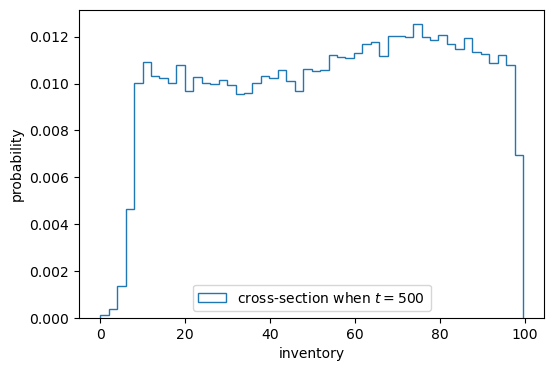

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(X, bins=50, 
        density=True, 
        histtype='step', 
        label=f'cross-section when $t = {T}$')
ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend(loc='lower center')
plt.show()


## Distribution dynamics

Next let’s take a look at how the distribution sequence evolves over time.

Here is code that repeatedly shifts the cross-section forward while
recording the cross-section at the dates in `sample_dates`.

All firms start at the same level `x_init`.

In [23]:
def shift_forward_and_sample(x_init, params, sample_dates,
                             num_firms=50_000):

    X = np.full(num_firms, x_init)
    X_samples = []
    # Simulate until the last sample date
    sim_length = sample_dates[-1] 
    # Use for loop to update X and collect samples
    for i in range(sim_length + 1):
        if i in sample_dates:
            X_samples.append(X)
        X = update_cross_section(params, X)

    return X_samples

Let’s test it

In [24]:
x_init = 50
num_firms = 10_000
sample_dates = 10, 50, 250, 500

X_samples = shift_forward_and_sample(x_init, params, sample_dates)

Let’s plot the output.

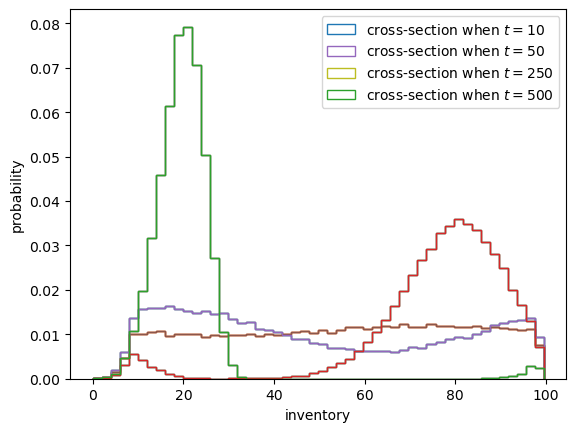

In [25]:
fig, ax = plt.subplots()

for i, date in enumerate(sample_dates):
    ax.hist(X_samples, bins=50, 
            density=True, 
            histtype='step',
            label=f'cross-section when $t = {date}$')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

## Exercise: Restock frequency

What's the probability a firm need to restock at least twice over periods $1, \ldots, 50$ when $ X_0 = 70 $?

Solve this by Monte Carlo:

* Set the number of firms to `1_000_000`.
* Calculate the fraction of firms that need to order twice or more in the first 50 periods.  

This proportion approximates the probability of the event (by the law of large numbers)

In [26]:
# Put your code here

In [28]:
for i in range(18):
    print("Solution below! 🐾")

Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾
Solution below! 🐾


In [29]:
def compute_freq(params,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):
    s = params.s
    # Set up cross-section of firms
    X = np.full(num_firms, x_init)
    # Restock counter starts at zero
    counter = np.zeros(num_firms)

    for i in range(sim_length):
        X = update_cross_section(params, X) 
        counter = np.where(X <= s, counter + 1, counter)
    return np.mean(counter > 1, axis=0)

In [30]:
freq = compute_freq(params)
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.554815
